## Проблема экстраполяции в решающих деревьях

Ансамбли решающих деревьев [не способны к эффективной экстраполяции](https://www.youtube.com/watch?v=buXRdy8VJm0&t=1336s). В частности, если в обучающих данных максимальное значение $i$-го признака было равно $x_i^{max}$, а при тестировании модель встретилась с еще большим значением этого признака: $x_i^{test} > x_i^{max}$, то ответ модели не будет зависеть от значения $x_i^{test} - x_i^{max}$. В целом проблема экстраполяции в том, что в областях, где обучающих данных было мало или они вовсе отсутствовали, получаемое решение будет константой или достаточно грубой кусочно-постоянной функцией (см. [habr](https://habr.com/ru/company/ods/blog/645887/), рис. 2).

Человеку, напротив, свойственно продолжать неизвестные зависимости плавной линией, что часто хорошо подтверждается в реальности. Нейронные сети в этом смысле лучше решающих деревьев, поскольку способны к экстраполяции выученных зависимостей.

Для примера возьмем датасет boston housing и сравним экстраполяцию нейронными сетями и решающими деревьями.

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, datasets, callbacks

(X, y), (X_test, y_test) = datasets.boston_housing.load_data()

def train_network(activation):
  model = Sequential([
      layers.Dense(1000, activation),
      layers.Dropout(0.5),
      layers.Dense(1000, activation),
      layers.Dropout(0.5),
      layers.Dense(1)])
  model.compile(loss='mse')
  model.history = callbacks.History()
  model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
            validation_data=(X_test, y_test),
            callbacks=callbacks.EarlyStopping(patience=10))
  val_losses = model.history.history['val_loss']
  print(f'Epochs: {len(val_losses)}, val loss: {val_losses[-1]:g}')
  return model

def test_extrapolation(model, examples, range=1):
  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 4))
  for i, ax in enumerate(axes.flat):
    _min, _max = X[:, i].min(), X[:, i].max()
    delta = _max - _min
    test_range = (_min - delta*range, _max + delta*range)
    test_values = np.linspace(*test_range, num=200)
    for example in examples:
      inputs = np.tile(example, (len(test_values), 1))
      inputs[:, i] = test_values
      predictions = model.predict(inputs).squeeze()
      ax.plot(test_values, predictions)
      ax.axvline(x=_min)
      ax.axvline(x=_max)

Epochs: 54, val loss: 58.861


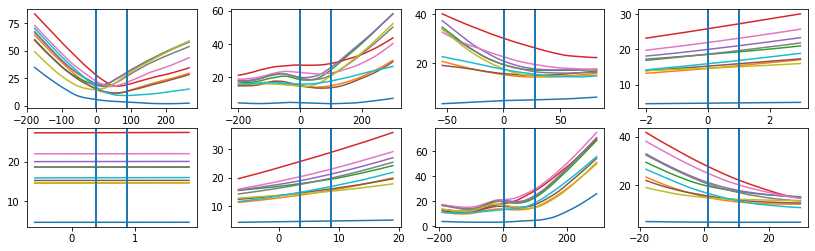

In [ ]:
model = train_network('relu')
test_extrapolation(model, X_test[:10], range=2)

Каждый график соответствует одному признаку, вертикальные линии обозначают минимальное и максимальное значение этого признака в обучающем датасете. Каждая линия соответствует одному тестовому примеру, в котором заменено только значение данного признака.

Проверим теперь сети с другой функцией активации и решающие деревья.

Epochs: 37, val loss: 29.3914


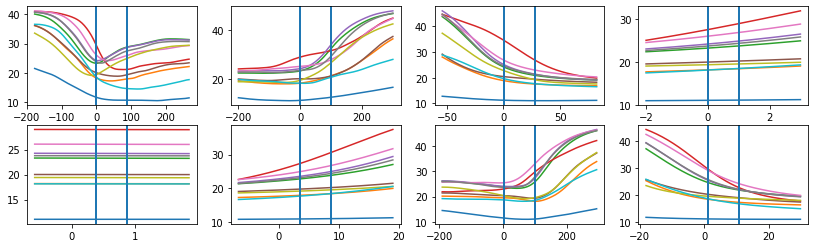

In [ ]:
model = train_network('sigmoid')
test_extrapolation(model, X_test[:10], range=2)

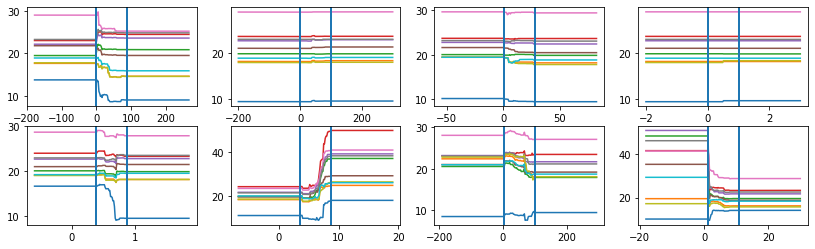

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000, max_depth=5).fit(X, y)
test_extrapolation(model, X_test[:10], range=2)

Как можно заметить, функция активации в нейронных сетях влияет на свойства экстраполяции, например, сети с ReLU обычно экстраполируют линейно. Нейрон с ReLU имеет два состояния, и по-видимому переключение состояний нейронов быстро прекращается при выходе за пределы многообразия обучающих данных, и функция становится линейной. В каких-то случаях это может быть неоптимально, например, если зависимость на самом деле логарифмическая.

Решающие деревья всегда экстраполируют константой. Является ли это неразрешимым ограничением, или же есть способ научить решающие деревья экстраполировать?

## Кусочно-линейные решающие деревья

Можно рассмотреть модификацию решающего дерева, в котором каждый лист соответствует не константному значению, а линейной функции от входных признаков. Такой подход рассматривался, например, в [Bishop, 2006]($Pattern Recognition and Machine Learning$), раздел 14.5.1. Однако особенность решающих деревьев в разреженности: если каждый лист будет функцией от всех признаков, то мы получим очень большое число параметров модели и долгое время обучения. Вместо  этого, каждый лист может быть линейной (либо квадратичной и т. д.) функцией лишь от одного признака.

Листья решающего дерева объединяются в пары, и можно дополнительно потребовать, чтобы каждая пара листьев использовала тот же признак, что в последнем разделяющем правиле, и давала в результате непрерывную функцию от этого признака (рис. 1).

<img src="assets/lineardt.png" width="400" align="center">

<center>Рис. 1. Кусочно-линейное разделяющее правило.</center>

Однако в таком случае дерево будет линейной функцией лишь от тех признаков, что использовались на последнем уровне (если это решающая таблица - то это лишь один признак). Но наибольшую важность, напротив, имеют те признаки, которые использовались на первых уровнях. Поэтому можно дополнительно потребовать, чтобы на последнем уровне использовался тот же признак, что и на первом уровне. Но это выглядит довольно искусственным решением, и при этом увеличивается сложность обучения.

Возможно ли создать дерево, которое будет кусочно-линейной функцией от всех признаков (кроме категориальных), которые в нем использовались? При этом желательно было бы соблюдение некскольких дополнительных свойств.

Введем следующее определение:

**Кусочно-линейная непрерывная нередуцируемая функция $N$-ного порядка** - это функция $f: \mathbb{R}^N \to \mathbb{R}$ такая, что:
1. Существует разбиение $P_f$ пространства $\mathbb{R}^n$ плоскостями такое, что на каждом участке функция $f$ является линейной. Назовем *прямоугольным разбиением* такое разбиение, что плоскости в нем параллельны координатным осям.
2. Функция $f$ является непрерывной.
3. Функция $f$ не представима в виде суммы функций от меньшего числа переменных (*нередуцируемость*).

Кусочно-линейным ансамблем будем называть сумму конечного числа таких функций. Последнее свойство является ключевым, так как определяет выризительную способность ансамбля (см. [habr](https://habr.com/ru/company/ods/blog/645887/), раздел "Выразительная способность ансамблей решающих деревьев"). Можно дополнительно потребовать, чтобы разбиение $P_f$ содержало каждый признак по одному разу, как в решающих таблицах.

Существуют ли вообще функции, обладающие такими свойствами? Рассмотрим случай $N=2$. Разбиение $P_f$ делит пространство на 4 части; без ограничения общности будем считать, что эти 4 части соответствовуют областям $x_1>0$, $x_1<0$, $x_2>0$, $x_2<0$, и $f(0, 0) = 0$.

Рассмотрим луч $x_1 = 0$, $x_2 > 0$, который проходит между двумя областями. Функция $f$ должна быть линейна на этом луче: $f(0, x_2) = c_1 x_2$. Аналогично, функция линейна на остальных трех лучах, идущих от точки $(0, 0)$ между областями. Этим лучам соответствуют коэффициенты $c_1, c_2, c_3, c_4$ (рис. 2).

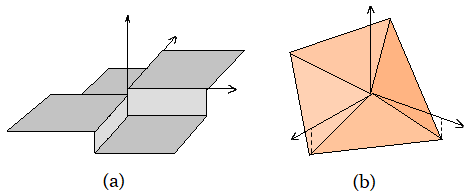

<center>Рис. 2. (a) Решающее дерево, использущее 2 переменные. (b) Кусочно-линейная непрерывная функция от 2 переменных.</center>

Рассмотрим срезы функции $f$, то есть частичное применение функции при двух произвольных значениях $x_1$: $f(x_1^a, \cdot)$, $f(x_1^b, \cdot)$. Обе эти функции будут иметь вид $c2*\text{ReLU}(x_2) + c4*\text{ReLU}(-x_2) + C$, отличаясь только на константу. Отсюда следует, что такая функция раскладывается в сумму функций от одной переменной: $f_1(x_1) + f_2(x_2)$, то есть не удовлетворяет свойству 3. По-видимому, похожим образом можно показать, что функция $f$ не будет удовлетворять свойству 3 и при большем числе областей в разбиении $P_f$.

Отсюда, следует, что вероятно **кусочно-линейных непрерывных нередуцируемых функций с прямоугольным разбиением не существует** (хотя строгое доказательство пока не получено). Если это так, то любая кусочно-линейная функция с прямоугольными областями либо разрывна, либо редуцируема в сумму функций от одной переменной. Тогда кусочно-линейное решающее дерево, в котором разделяющие правила используют по одному признаку, либо дает разрывную функцию, либо редуцируемо и не имеет смысла (так же, как не имеет смысла нейронная сеть с широкими промежуточными слоями без функции активации).

Простым примером кусочно-линейной непрерывной нередуцируемой функции 2-го порядка с **непрямоугольным разбиением** $P_f$ является функция $\text{ReLU}(x_1 + x_2)$. На таких функциях основаны нейронные сети с одним скрытым слоем, являющиеся универсальными аппроксиматорами.

В результате получен набросок доказательства того, что кусочно-линейные решающие деревья, в которых решающие правила используют по одному признаку, вынужденно дают разрывные функции. Впрочем, нет серьезных оснований считать, что это плохо, ведь таковы почти все современные решающие деревья, и при этом они хорошо работают на практике. Но свойство непрерывности, будь оно выполнено, позволило бы эффективнее оптимизировать структуру дерева, в том числе выполнять дообучение градиентным спуском и файг-тюнинг при сдвиге данных.

Это **не означает**, что кусочно-линейные решающие деревья не имеют смысла. Вполне возможно, что они, наоборот, могут оказаться эффективнее стандартных кусочно-постоянных деревьев.

## Оптимизация деревьев градиентным спуском

Ансамбль решающих деревьев можно представить в виде нейронной сети.

Если в ансамбле используется $N$ разных решающих правил, то их можно представить как $N$ нейронов с пороговой функцией активации. Эти нейроны составляют **первый слой** сети (как вариант, можно сразу посчитать значения на них для всех примеров и получить для каждого примера вектор из $N$ признаков).

**Второй слой** сети содержит столько нейронов, сколько суммарно листьев во всех деревьях. Если все деревья имеют глубину $M$, то каждый лист активируется при одновременной активации $M$ определенных нейронов первого слоя. Если от каждого из этих нейронов провести связь с весом $1/M$, и bias нейрона принять равным $-1$, то выполнение всех условий означает величину $0$ на входе нейрона, а невыполнение - величину меньше 0. Нейроны второго слоя могут тоже иметь пороговую функцию активации.

**Третий слой** является выходным и содержит один нейрон (в задаче регрессии), а веса, идущие от второго слоя к третьему, соответствуют значениям на листьях.

Такая нейронная сеть будет эквивалентна исходному ансамблю решающих деревьев. С ней можно провести различные эксперименты, такие как:

1. Заменить все слои, кроме первого, и обучить их заново. Это означает, что исходный ансамбль будет выполнять роль экстрактора бинарных признаков. Признаки можно сгладить, заменив пороговую функцию активации на сигмоиду. Это как раз то, что предлагает Дмитрий Колодезев в ODS Lab.
2. Можно не заменять слои и попробовать дообучить сеть, которая при инициализации была эквивалентна исходному ансамблю деревьев. Для этого можно либо заменить во всех слоях функцию активации на сигмоиду (подобрав коэффициенты сжатия по горизонтали для сигмоид), либо применяя градиент от сигмоиды при обратном распространении ошибки:

In [ ]:
@tf.custom_gradient
def heaviside(x):
  grad = lambda dy: dy * tf.nn.sigmoid(x) * (1 - tf.nn.sigmoid(x))
  return tf.math.sign(x)*0.5 + 0.5, grad

В результате мы получим возможность:
1. Дообучить модель и возможно улучшить ее качество
2. Файн-тюнить модель при сдвиге данных
1. Выполнять инференс теми же методами, что и в нейронных сетях.

Конечно, попытки обучать градиентным спуском модели, похожие на решающие деревья, предпринимались многократно.

> Since decision trees are not differentiable and do not allow gradient optimization, they cannot be used as a component for pipelines trained in the end-to-end fashion. To address this issue, several works ([Hazimeh et al., 2020]($The tree ensemble layer: Differentiability meets conditional computation$); [Kontschieder et al., 2015]($Deep Neural Decision Forests$); [Popov et al., 2020]($Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data$); [Yang et al., 2018]($Deep Neural Decision Trees$)) propose to "smooth" decision functions in the internal tree nodes to make the overall tree function and tree routing differentiable. While the methods of this family can outperform GBDT on some tasks ([Popov et al., 2020]($Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data$)), in our experiments, they do not consistently outperform ResNet. ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$))

## Почему решающие деревья эффективны?

В настоящее время решающие деревья считаются одними из самых эффективных моделей машинного обучения.

> While deep learning models are more appropriate in fields like image recognition, speech recognition, and natural language processing, tree-based models *consistently outperform standard deep models* on tabular-style datasets where features are individually meaningful and do not have strong multi-scale temporal or spatial structures. ([Lundberg et al., 2019]($Explainable AI for Trees: From Local Explanations to Global Understanding$))

Недавно было проведено исследование ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$)) со сравнением нейронных сетей и градиентного бустинга. В результате оказалось, что на некоторых задачах лучше работают нейронные сети, а на некоторых градиентный бустинг. Авторы также предлагают архитектуру FT-Transformer, которая хорошо работает на тех задачах, на которых обычные нейронные сети (ResNet) уступают градиентному бустингу.

> ...we have proposed FT-Transformer — a simple adaptation of the Transformer architecture that outperforms other DL solutions on most of the tasks. We have also compared the new baselines with GBDT and demonstrated that GBDT still dominates on some tasks. ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$))

При этом ансамбли решающих деревьев фиксированной глубины $N$ [не являются](https://habr.com/ru/company/ods/blog/645887/) универсальными аппроксиматорами и представимы как сумма функций не более чем от $N$ переменных.

Можно попробовать обосновать эффективность решающих деревьев следующими гипотезами:

1. **Гипотеза простой зависимости**. Большая часть зависимостей на табличных данных может быть хорошо аппроксимирована суммой функций от небольшого числа переменных. Если это было бы не так, то решающие деревья небольшой глубины не достигали бы хорошей точности на табличных датасетах. Введем для этой гипотезы сокращение: SP-гипотеза (simplicity prior).

2. **Гипотеза условной зависимости**. Некоторые признаки имеют значение лишь при определенных значениях других признаков.

3. **Гипотеза разреженной блок-схемы**. Многие целевые зависимости на табличных данных можно аппроксимировать блок-схемой принятия решения, которая имеет свойство разреженности (на каждом шаге используется лишь 1-2 признака). Эта гипотеза объединяет SP-гипотезу и гипотезу условной зависимости и также имеет связь с consciousness prior ([Bengio, 2017]($The Consciousness Prior$)).

Конечно, это лишь гипотезы: возможно, что эффективность решающих деревьев обусловлена вовсе не этим.

Исследователи еще с XX века задумывались тем, что схема принятия решений часто должна быть разреженной. Для достижения разреженности в линейной регрессии и нейронных сетях иногда применяют l1-регуляризацию (lasso). Поскольку градиент l1-регуляризации никогда не стремится к нулю при ненулевых весах, при выпуклой функции потерь на поздних стадиях оптимизации он приобретает первоочередное значение, в результате многие веса сети сходятся к нулевым значениям (в отличие от L2-регуляризации).

> There has also been much deep and interesting work on the mathematical aspects of the lasso, examining its ability to produce a model with minimal prediction error, and also to recover the true underlying (sparse) model. ([Tibshirani, 2011]($Regression shrinkage and selection via the lasso: a retrospective$))

Нейронные сети в целом не следуют SP-гипотезе. Даже если мы добьемся того, что большая часть весов сети будет равна нулю, сеть в целом скорее всего не будет представима как сумма функций от небольшого числа признаков.

Пример сети с 2 скрытыми слоями по 1000 нейронов, обученной с l1-регуляризацией на датасете boston housing:

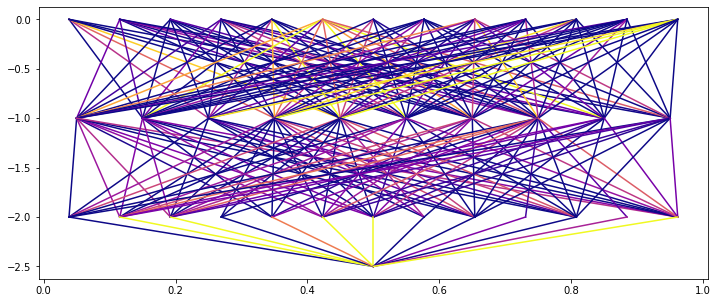

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers, datasets, callbacks, regularizers, optimizers
import sklearn.preprocessing

(X, y), (X_test, y_test) = datasets.boston_housing.load_data()

scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
scaler = sklearn.preprocessing.StandardScaler()
y = scaler.fit_transform(y[:, None])[:, 0]
y_test = scaler.transform(y_test[:, None])[:, 0]

model = Sequential([
    layers.Dense(1000, 'relu', kernel_regularizer=regularizers.l1(l1=2e-3)),
    layers.Dense(1000, 'relu', kernel_regularizer=regularizers.l1(l1=8e-3)),
    layers.Dense(1, kernel_regularizer=regularizers.l1(l1=8e-3))])
model.compile(loss='mse', optimizer=optimizers.Adam(1e-4))
model.history = callbacks.History()
model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
         validation_data=(X_test, y_test),
         callbacks=callbacks.EarlyStopping(patience=25))
val_losses = model.history.history['val_loss']
print(f'Epochs: {len(val_losses)}, val loss: {val_losses[-1]:g}')

threshold = 1e-4
plt.figure(figsize=(12, 5))
cmap = plt.get_cmap('plasma')
y_pos = [0, -1, -2, -2.5]

W1, b1 = model.layers[0].get_weights()
W2, b2 = model.layers[1].get_weights()
W3, b3 = model.layers[2].get_weights()
neuron_ids = [
      list(range(X.shape[1])),
      list(np.where((np.abs(W1).max(axis=0) > threshold) \
            & (np.abs(W2).max(axis=1) > threshold))[0]),
      list(np.where((np.abs(W2).max(axis=0) > threshold) \
            & (np.abs(W3).max(axis=1) > threshold))[0]),
      [0]]

for i, layer in enumerate(model.layers):
  W, b = layer.get_weights()
  for from_neuron in range(W.shape[0]):
    for to_neuron in range(W.shape[1]):
      value = W[from_neuron, to_neuron]
      if np.abs(value) > threshold:
        try:
          x1 = (0.5 + neuron_ids[i].index(from_neuron)) / len(neuron_ids[i])
          x2 = (0.5 + neuron_ids[i+1].index(to_neuron)) / len(neuron_ids[i+1])
          plt.plot([x1, x2], [y_pos[i], y_pos[i+1]], color=cmap(value*3))
        except:
          pass
plt.show()

L1-регуляризация уменьшает число нейронов, имеющих ненулевые связи (на рисунке показаны только нейроны, имеющие входные или выходные связи с весами больше 0.001 по модулю), но граф связности между этими нейронами по прежнему остается почти полносвязным, и такая сеть не раскладывается в сумму функций от небольшого числа переменных.

Высокую эффективность при обучении на табличных данных показывают сети архитектуры ResNet (с пробросом связей через несколько слоев).

> First, we reveal that none of the considered DL models can consistently outperform the ResNet-like model. Given its simplicity, it can serve as a strong baseline for future work. ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$))

Хотя проброс связей не увеличивает выразительную способность сети, он влияет на свойства точки инициализации, от которой начинается процесс оптимизации. Если в MLP-сети точка инициализации представляет собой запутанную функцию от всех переменных, совершенно непохожую на линейную, то в ResNet-сетях точка инициализации уже ближе к линейной функции. Например, в [Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$) на табличных данных тестируются сети такого вида:

$\text{Linear} \to \text{ResNetBlock} \to \dots \to \text{ResNetBlock} \to \text{BatchNorm} \to \text{ReLU} \to \text{Linear}$

Где $\text{ResNetBlock}(x) = x + f(x)$, и $f(x)$ имеет следующий вид:

$\text{BatchNorm} \to \text{Linear} \to \text{ReLU} \to \text{Dropout} \to \text{Linear} \to \text{Dropout}$

За счет проброса связей ResNet'ы имеют свойство реализовывать более простые и близкие к линейным функции, чем MLP, что имеет связь с гипотезой простой зависимости, но все же не соответствует ей до конца.

Возможно, недостаточное соответствие нейронных сетей SP-гипотезе является одной из причин того, что решающие деревья часто показывают лучшие результаты на табличных датасетах.

## Реализация SP-гипотезы в нейронных сетях

Можно предложить модификации нейронных сетей, с помощью которых удастся достичь большего соответствия SP-гипотезе. Для этого мы должны каким-то образом изменить пространство поиска решения, то есть заставить сеть предпочитать решения, представимые в виде суммы функций от небольшого числа признаков. Важным свойством таких сетей может стать **интерпретируемость**.

Самый простой способ явно привести сеть в соответствие SP-гипотезе - это искать ответ в виде суммы ответов подсетей, каждая из которых обрабатывает лишь несколько признаков. Но количество комбинаций признаков может быть очень велико: например, существует $1.2*10^9$ комбинаций 6 из 100 признаков - таким же должно быть и количество подсетей. Значит мы должны рассматривать не все возможные комбинации. есть несколько вариантов выбрать нужные комбинации:

1. Обучить ансамбль решающих деревьев глубиной $N$, разложить его в сумму функций от $N$ признаков и использовать только те комбинации признаков, которые встретились в данном разложении.

2. Обучить набор подсетей, каждая из которых использует только один признак, и затем пробовать добавлять к этим сетям признаки по одному и сохранять изменения, если они привели к росту точности. Так мы получаем жадный алгоритм поиска перебором - такой же, как используется в решающих деревьях. Можно либо неограниченно растить количество подсетей (как в градиентном бустинге), либо ограничиться фиксированным числом подсетей и итеративно добавлять в них признаки. Градиентный бустинг над нейронными сетями был также предложен в [Badirli et al., 2020]($Gradient Boosting Neural Networks: GrowNet$), хотя по существу описанный авторами метод больше напоминает стекинг, либо послойное обучение с суммированием выходов всех слоев.

3. Обучить набор подсетей, каждая из которых использует случайный небольшой набор признаков, и пробовать удалять из этих сетей признаки по одному и сохранять изменения, если они привели к росту точности. Этот метод похож на предыдущий, но действует "в обратную сторону" - через удаление, а не добавление.

4. Обучить набор подсетей, каждая из которых использует случайный небольшой набор признаков, наложив на эти сети сильную L1-регуляризацию весов (или другую подобную ей). Тогда сети сами отбросят ненужные признаки. Далее можно использовать либо сами сети в том виде, в каком они получены, либо использовать наборы признаков, которым в сетях соответствовали ненулевые веса, и обучать новые сети с помощью этих наборов признаков.

5. Использовать комбинацию двух и более перечисленных выше методов.

Предложенные методы очень общие и конкретные реализации могут сильно различаться. Если удастся эффективно реализовать какой-либо из предложенных методов, то решение будет получено в виде ансамбля (суммы) небольших нейронных сетей.

Наконец, еще один подход может заключаться в том, что мы не выбираем явно небольшие наборы признаков, а передаем на вход сети одновременно все признаки (как в обычных нейронных сетях), но при этом находим способ регуляризации, заставляющий сеть предпочитать решения, приблизительно соответствующие SP-гипотезе. Нахождение такого способа регуляризации может быть предметом дальнейших исследований.

Также возможно, что целевую переменную удобнее будет представлять не в виде суммы функций от небольшого числа входных признаков, а в виде суммы функций от небольшого числа скрытых переменных, получаемых линейной комбинацией исходных признаков (например, с помощью PCA или обучаемого линейного слоя).

Остается еще одна проблема, связанная с SP-гипотезой. Допустим, целевая переменная хорошо аппроксимируется суммой функций от 3 переменных. Если мы возьмем экспоненту от целевой переменной (в машинном обучении часто делают подобные преобразования) то сумма станет произведением. Будет ли такое произведение представимо в виде другой суммы (в границах многообразия данных)?

$y \approx \sum\limits_{i, j, k} f_{i, j, k}(x_i, x_j, x_k)$

$\exp y \approx \prod\limits_{i, j, k} \exp f_{i, j, k}(x_i, x_j, x_k) \overset{\large{?}}{\approx} \sum\limits_{i, j, k} g_{i, j, k}(x_i, x_j, x_k)$

Нет оснований считать, что такая аппроксимация всегда будет точна. Вполне возможно, что для каждой задачи существует такое монотонное преобразование целевой переменной, при котором она наилучшим образом представляется в виде суммы функций от небольшого числа входных признаков. Поэтому в нейронную сеть можно добавить обучаемое преобразование целевой переменной. Следуя этой идее, также можно добавить обучаемое преобразование от каждого входного признака:

<img src="assets/scheme.jpg" width="300" align="center">

<center>Рис. 3. Схема предлагаемой нейронной сети.</center>

Преобразования признаков в машинном обучении обычно монотонны, чтобы избежать потери информации. Но в случае обучаемых преобразований можно также разрешить немонотонные преобразования.

Каждое преобразование ($g_i$ и $h$) является обучаемой моделью, и хотелось бы, чтобы эта модель не была излишне сложной. При этом желательна достаточная выразительность этой модели, то есть возможность реализации таких функций, как $Cx$, $ln (x)$, $exp (x)$, $x^2$, и возможно также quantile transformation (приведение выборочного распределения к приблизительно равномерному).

## Revisiting Deep Learning Models for Tabular Data

В недавней статье "Revisiting Deep Learning Models for Tabular Data" от Яндекса ([Gorishniy et al., 2021]($Revisiting Deep Learning Models for Tabular Data$), см. также [презентацию](https://youtu.be/ObzrXjqWcTY?t=1445)) авторы сравнивали эффективность различных моделей машинного обучения на табличных данных. При этом:

1. Сравнивались 11 моделей, в том числе XGBoost, CatBoost, MLP, [ResNet](https://github.com/yandex-research/rtdl/blob/main/bin/resnet.py), [FT-Transformer](https://github.com/yandex-research/rtdl/blob/main/bin/ft_transformer.py).
2. Для сравнения использовались 11 датасетов для классификации и регрессии, в том числе California Housing, Adult income estimation, Higgs, Covertype и другие. Датасеты имели от 20 тысяч до 1.2 миллиона примеров и от 8 до 2000 признаков. 
3. Использовалось только одно (одинаковое для всех моделей) деление датасетов на обучающую, валидационную и тестовую части. Подбор гиперпараметров осуществлялся на валидационной части.
4. Модели сравнивались сначала с параметрами по-умолчанию, затем осуществлялся подбор гиперпараметров методом TPE (Tree-structured Parzen Estimator) с помощью библиотеки Optuna, при этом количество итераций подбора было одинаковым для всех моделей (время подбора могло различаться).
5. Точность моделей оценивалась по средней метрике качества по 15 попыткам обучения. Полученные 15 моделей ансамблировались в три группы по 5 моделей, и метрика усреднялась по трем ансамблям. В результате для каждой модели были получены средняя точность одиночной модели и средняя точность ансабмля из 5 моделей.

В результате на разных датасетах показали наилучшее качество разные модели.

- Среди *одиночных моделей* FT-Transformer достиг наилучшей точности на 4 из 11 датасетов, остальные модели не более чем на 2 из 11 датасетов. На 7 из 11 датасетах наилучшей точности достигла одна из  нейросетевых моделей.
- После *ансамблирования* FT-Transformer показывает наилучшую точность на 5 из 11 датасетах, CatBoost на 3 из 11 датасетах, остальные модели - не более чем на одном датасете. Снова на 7 из 11 датасетах (тех же самых) наилучшей точности достигла одна из  нейросетевых моделей.

Также все 11 моделей были протестированы на ряде [синтетических датасетов](https://github.com/yandex-research/rtdl/blob/main/lib/synthetic_data.py), которые были получены по формуле $y = \alpha f_\text{GBDT}(x) + (1-\alpha) f_\text{DL}(x)$, где $f_\text{GBDT}$ - ансамбль из 30 случайных решающих деревьев и $f_\text{DL}$ - ансамбль из 30 MLP-сетей с тремя случайно инициализированными скрытыми слоями.

На этих данных авторы сравнили три архитектуры: GBDT, ResNet и FT-Transformer. Естественно, что чем больше $\alpha$, тем хуже обобщался на этих модельных данных ResNet и лучше обобщался градиентный бустинг. При этом получен интересный результат: FT-Transformer обобщался почти не хуже решающих деревьев и почти не хуже ResNet при всех $\alpha$.

<img src="assets/ft.png" width="400" align="center">

<center>Рис. 4. GBDT, ResNet и FT-Transformer на модельной задаче.</center>

Конечно, данный бенчмарк нельзя назвать исчерпывающим. Например, категориальные признаки присутствовали лишь в одном из 11 реальных датасетов, также не было датасетов с небольшим числом примеров. Но дело не только в этом. В данном бенчмарке рассчитывается только усредненная метрика качества при тестировании (RMSE, accuracy). Это может помочь найти наилучшие модели, но не поможет понять причину того, что одни модели обобщаются лучше других. Чтобы разобраться в этом вопросе, нужно более детально изучать обучение и поведение модели.

## Способы анализа нейронных сетей и решающих деревьев

Перечисленные ниже способы могут помочь понять причину того, что они модели обобщаются лучше или хуже других.

**Первый способ.** Обучить модель многократно на подвыборках разного размера из некоего большого датасета. Так мы сможем измерить систематическую (bias) и несистематическую (variance) ошибку модели.

**Второй способ.** Изучение свойств функции, реализуемой моделью, до и после обучения. Для этого можно взять один тестовый пример и проследить, как меняется предсказание модели при изменении того или иного признака (двухмерный график) или сразу двух признаков (трехмерный график). Также можно взять два или три тестовых примера и проследить, как меняется предсказание модели при плавном переходе между ними.

- Вид полученных функций поможет лучше понять общие свойства функции от многих переменных, реализуемой моделью, так как в данном способе мы изучаем срезы этой функции. 
- Сравнение функций до и после обучения может помочь понять, как модель обучается и какие решения среди всего пространства поиска предпочитает алгоритм обучения, а каких решений избегает (даже если они есть в пространстве поиска).

Идеальной была бы ситуация, когда мы имеем в явном виде целевую функцию, и тогда мы сможем сравнить полученные функции с верными. Однако целевую функцию в явном виде мы имеем только на синтетических датасетах, работа моделей на которых может быть не показательной, так как они отличаются от реальных. На реальных данных хорошую аппроксимацию целевой функции можно получить, обучив ансамбль из моделей разных архитектур на большом датасете. Полученную функцию можно считать близкой к эталонной, и с ней сравнивать функции, реализуемые моделями, обученными на существенно меньшем объеме данных.

**Третий способ.** Кроме расчета усредненной метрики качества по всей тестовой выборке, можно измерить метрику на отдельных типах примеров, например одним из следующих способов:
- Разбив выборку на части по значению одного из исходных признаков.
- Разбив выборку на части по значению целевого признака.
- Выполнив кластеризацию выборки по SHAP values.

Таким образом мы сможем выявить ситуацию, когда модель $A$ дает качество лучше, чем модель $B$ на большинстве примеров, но сильную ошибку на отдельных типах примеров, из-за чего усредненная метрика качества у модели $B$ оказывается выше.

## Свойства решений, получаемых нейронными сетями и решающими деревьями

В этом разделе мы попробуем изучить различные модели с помощью замены значений одного из признаков на тестовых примерах. В результате мы получим набор графиков, и пример такого графика показан на рис. 5.

<img src="assets/example.png" width="250" align="center">

<center>Рис. 5. Пример графиков, получаемых при изменении одного из признаков на тестовых примерах.</center>

Сначала рассмотрим принцип построения такого графика. Каждая линия соответствует одному тестовому примеру, в котором значение 7-го признака заменено на значение, отложенное по оси X. По оси Y показана величина предсказания в обученной модели. 10 тестовых примеров тестировались сначала на сети до обучения (оранжевые графики), затем после обучения (зеленые графики). Вертикальными линиями отмечены минимальное и максимальное значение признака в тестовой выборке.

Для тестирования будем использовать датасет California housing - задача предсказания цены недвижимости по набору из 8 количественных признаков. Будем исследовать поведение моделей при изменении этих признаков.

Для начала загрузим датасет и напишем несколько вспомогательных функций.

In [1]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets, sklearn.model_selection, sklearn.ensemble
from tensorflow.keras import Sequential, layers #, datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error as mse

# help functions

def test_changing_feature(model, examples, feature_idx, values_range, num=300):
  feature_values = np.linspace(*values_range, num=num)
  predictions = []
  for example in examples:
    inputs = np.tile(example, (len(feature_values), 1))
    inputs[:, feature_idx] = feature_values
    predictions.append(model.predict(inputs).squeeze())
  return feature_values, np.array(predictions).T

def multi_plot(plots, ncols=None, axes=None, op='plot', h=3, w=3, **kwargs):
  ncols = ncols or min(4, len(plots))
  nrows = (len(plots) - 1)//ncols + 1
  figsize = (ncols*w, nrows*h)
  if axes is None:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
  for i, ax in enumerate(axes.flat):
    if i < len(plots):
      if plots[i] is not None:
        if type(plots[i]) == tuple:
          getattr(ax, op)(*plots[i], **kwargs)
        else:
          getattr(ax, op)(plots[i] , **kwargs)
    else:
      ax.remove()
  return axes

def get_range(X, feature_idx, padding=0):
  _min, _max = X[:, feature_idx].min(), X[:, feature_idx].max()
  delta = _max - _min
  return _min - delta*padding, _max + delta*padding

def draw_vertical_lines(ax, positions, color='C0'):
  for pos in positions:
    ax.axvline(x=pos)

def copy_model(model):
  new_model = tf.keras.models.clone_model(model)
  new_model.set_weights(model.get_weights())
  return new_model

def report_loss(model, X_train, y_train, X_test, y_test):
  epochs = len(model.history.history['loss'])
  train_loss = model.evaluate(X_train, y_train, verbose=0)
  test_loss = model.evaluate(X_test, y_test, verbose=0)
  print(f'Epochs: {epochs}, last train MSE {train_loss:g} min test MSE {test_loss:g}')

def plot_loss(model):
  plt.loglog(model.history.history['loss'], label='train')
  plt.loglog(model.history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

def test_changing_features_and_plot(*models, n_examples=10, padding=0.2, labels=None):
  axes = multi_plot([None] * 8)
  colors = ['C2', 'C1', 'C3', 'C4', 'C5']
  for i, model in enumerate(models):
    preds = [test_changing_feature(model, X_test[:n_examples], feature_idx=i,
              values_range=get_range(X_train, i, padding=padding))
          for i in range(8)]
    multi_plot(preds, axes=axes, color=colors[i])
  for i, ax in enumerate(axes.flat[:8]):
    ax.set_title(f'Changing feature {i}')
    draw_vertical_lines(ax, get_range(X_train, i, padding=0))
  plt.tight_layout()
  if len(models) > 1:
    axes.flat[7].legend(
        [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(models))],
        labels or ['Trained', 'Untrained'])
  plt.show()

def show_weights_change(trained_model, untrained_model, layer_ids, s=0.5):
  data = []
  for i in layer_ids:
    W_untrained = untrained_model.layers[i].get_weights()[0]
    W_trained = trained_model.layers[i].get_weights()[0]
    neurons_to_plot = np.random.choice(range(W_untrained.size), 5000)
    data.append((W_untrained.flat[neurons_to_plot], W_trained.flat[neurons_to_plot]))
  axes = multi_plot(data, op='scatter', s=s)
  for ax, layer_idx in zip(axes.flat, layer_ids):
    ax.set_title(f'Layer {layer_idx} weights')
    ax.set_xlabel('untrained')
    ax.set_ylabel('trained')
  plt.tight_layout()
  plt.show()

Из датасета удалим строки с выбросами, так как известно, что нейросети неустойчиво обучаются при больших значениях, подаваемых на вход. Тем самым в эксперименте мы избавимся от лишних проблем.

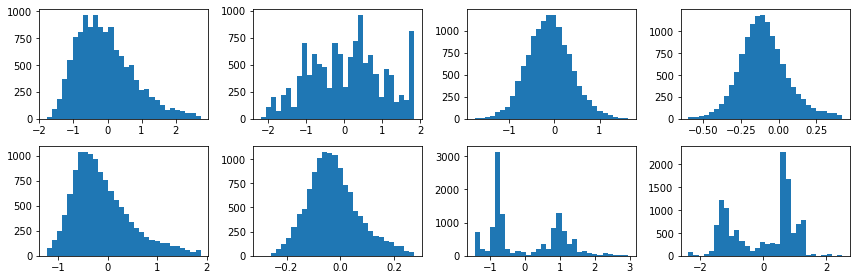

In [2]:
# dataset

#(X_train, y_train), (X_test, y_test) = datasets.boston_housing.load_data()
X, y = sklearn.datasets.fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y,
                                                          test_size=0.33, random_state=0)

# стандартизация
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler = sklearn.preprocessing.StandardScaler()
y_train = scaler.fit_transform(y_train[:, None])[:, 0]
y_test = scaler.transform(y_test[:, None])[:, 0]

# удаление строк с выбросами
q3 = np.quantile(X_train, 0.75, axis=0)
q1 = np.quantile(X_train, 0.25, axis=0)
lower_bound = q1 - 2*(q3 - q1)
upper_bound = q3 + 2*(q3 - q1)
train_condition = (X_train >= lower_bound[None]).all(axis=1) \
                & (X_train <= upper_bound[None]).all(axis=1)
test_condition = (X_test >= lower_bound[None]).all(axis=1) \
               & (X_test <= upper_bound[None]).all(axis=1)
X_train = X_train[train_condition]
y_train = y_train[train_condition]
X_test = X_test[test_condition]
y_test = y_test[test_condition]

multi_plot([X_train[:, i] for i in range(8)], op='hist', bins=30, h=2)
plt.tight_layout()
plt.show()

Посмотрим на распределение целевого признака.

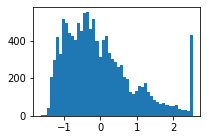

In [3]:
plt.figure(figsize=(3, 2))
plt.hist(y_train, bins=50);

Видно, что значения целевого признака обрезаны выше некоего порога. Предсказывать целевую переменную в таком виде, кажется, будет неоптимально. Вместо этого лучше обрезать ответ модели до значения порога, чтобы не штрафовать предсказания выше порога. Но это усложнит код, поэтому просто удалим лишние значения.

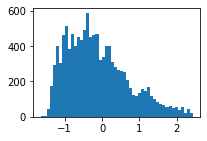

In [4]:
train_condition = (y_train.max() - y_train) > 0.1
test_condition = (y_test.max() - y_test) > 0.1
X_train = X_train[train_condition]
y_train = y_train[train_condition]
X_test = X_test[test_condition]
y_test = y_test[test_condition]

plt.figure(figsize=(3, 2))
plt.hist(y_train, bins=50);

Начнем с нейронной сети следующей простой архитектуры, используя первые 500 обучающих примеров и первые 1500 тестовых примеров.

In [ ]:
model = Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.Dense(2000, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(2000, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(1)
])
untrained_model = copy_model(model)
model.compile(loss='mse', optimizer=Adam(1e-3))
model.fit(X_train[:500], y_train[:500], batch_size=8, epochs=1000, verbose=0,
            validation_data=(X_test[:1500], y_test[:1500]),
            callbacks=EarlyStopping(patience=30, restore_best_weights=True));
report_loss(model, X_train[:500], y_train[:500], X_test[:1500], y_test[:1500])

Epochs: 60, last train MSE 0.115859 min test MSE 0.202742


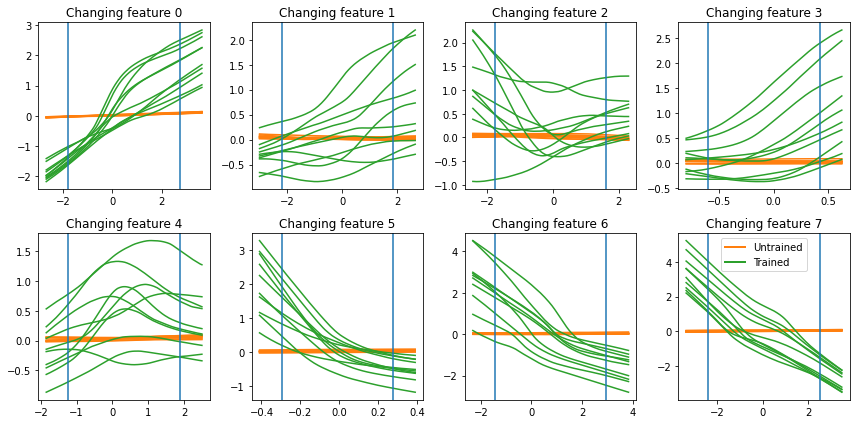

In [ ]:
test_changing_features_and_plot(model, untrained_model)

Несмотря на то, что сеть с ReLU представляет собой кусочно-линейную функцию, она выглядит как гладкая функция и до, и после обучения, за счет большого количества нейронов.

Проверим, насколько сильно изменились значения весов в процессе обучения.

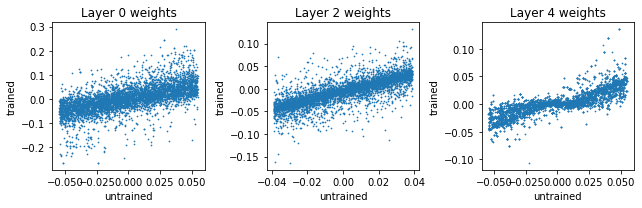

In [ ]:
show_weights_change(model, untrained_model, [0, 2, 4])

Как можно видеть, веса изменились не слишком сильно: те веса, что были больше нуля до обучения, обычно остаются больше нуля и после обучения, и наоборот.

Теперь попробуем нейронную сеть с пробросом связей (ResNet).

In [ ]:
class ResidualBlock(Sequential):
  def call(self, inputs, training=None):
    return inputs + super().call(inputs, training=training)

model = Sequential([
  layers.InputLayer(X_train.shape[1]),
  layers.Dense(1000),
  ResidualBlock([
      layers.LayerNormalization(),
      layers.Dense(1000, 'relu'),
      layers.Dropout(0.5)
  ]),
  ResidualBlock([
      layers.LayerNormalization(),
      layers.Dense(1000, 'relu'),
      layers.Dropout(0.5)
  ]),
  layers.Dense(1)
])

untrained_model = copy_model(model)
model.compile(loss='mse', optimizer=Adam(1e-4))
model.fit(X_train[:500], y_train[:500], batch_size=8, epochs=1000, verbose=0,
            validation_data=(X_test[:1500], y_test[:1500]),
            callbacks=EarlyStopping(patience=30, restore_best_weights=True));
report_loss(model, X_train[:500], y_train[:500], X_test[:1500], y_test[:1500])

Epochs: 130, last train MSE 0.139867 min test MSE 0.196759


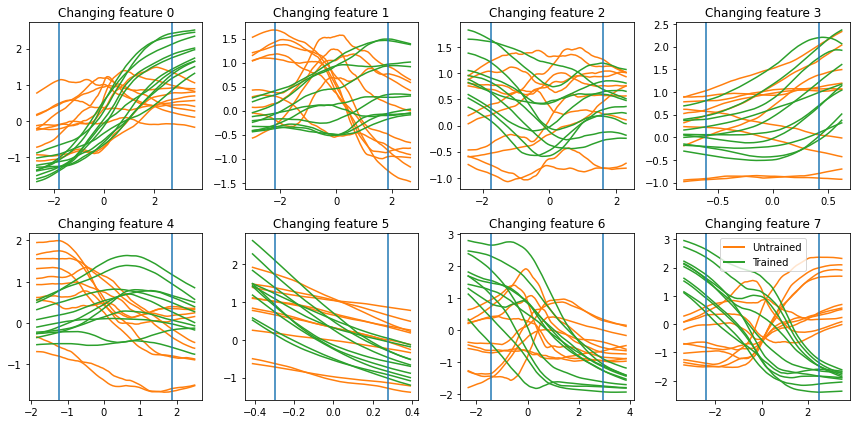

In [ ]:
test_changing_features_and_plot(model, untrained_model)

В целом графики получаются достаточно похожими, хотя в этом случае менее гладкими, и предсказание сильнее отличается от нуля при инициализации. Точность на тестовой выборке получается приблизительно такой же.

Теперь попробуем нейронную сеть без dropout с другой функцией активации и инициализацией весов.

Epochs: 50, last train MSE 0.00178417 min test MSE 0.693572


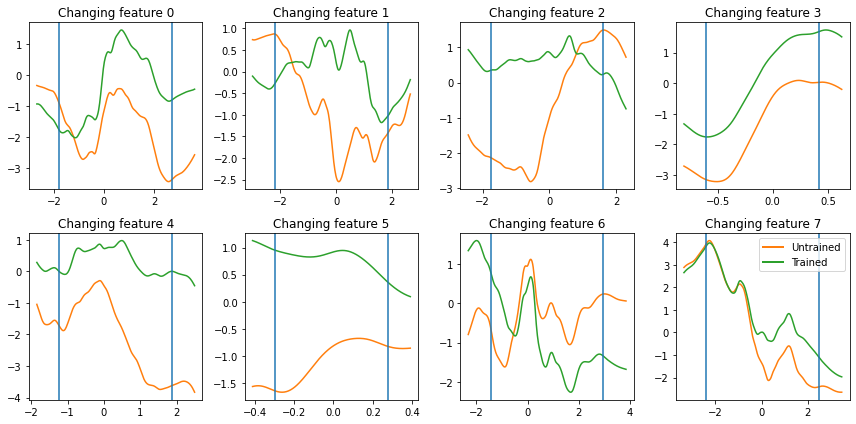

In [ ]:
model = Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.Dense(2000, 'tanh', kernel_initializer=RandomNormal(stddev=1)),
    layers.Dense(2000, 'tanh', kernel_initializer=RandomNormal(stddev=0.2)),
    layers.Dense(1, kernel_initializer=RandomNormal(stddev=0.05))
])
untrained_model = copy_model(model)
model.compile(loss='mse', optimizer=Adam(1e-4))
model.fit(X_train[:500], y_train[:500], batch_size=64, epochs=100, verbose=0,
            validation_data=(X_test[:1500], y_test[:1500]),
            callbacks=EarlyStopping(patience=30, restore_best_weights=True));
report_loss(model, X_train[:500], y_train[:500], X_test[:1500], y_test[:1500])

test_changing_features_and_plot(model, untrained_model, n_examples=1)

Посмотрим, как изменились веса.

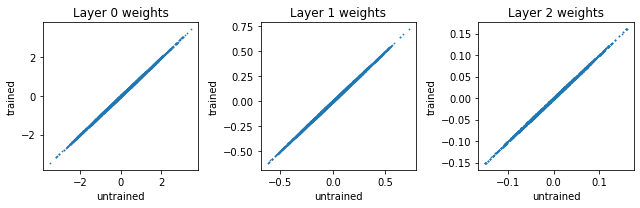

In [ ]:
show_weights_change(model, untrained_model, [0, 1, 2])

Видно, что графики до и после обучения попарно схожи, и точность сети при тестировании при этом получается хуже, чем у линейной регрессии.

С одной стороны, обе рассмотренные сети имеют большую емкость (миллионы весов), и теоретически могут реализовать почти любую функцию с хорошей точностью. Но с другой стороны, каждая модель сходится к решениям, обладающим определенными свойствами, зависящими от начальной инициализации, алгоритма оптимизации, способов регуляризации. Эти свойства оказывают принципиальное влияние на обобщающую способность.

Похожее исследование проводилось в работе [Neal, 1994]($Priors for Infinite Networks$).

Теперь проверим работу анасамблей решающих деревьев на этой же задаче.

Train MSE 0.000277266, Test MSE 0.208791


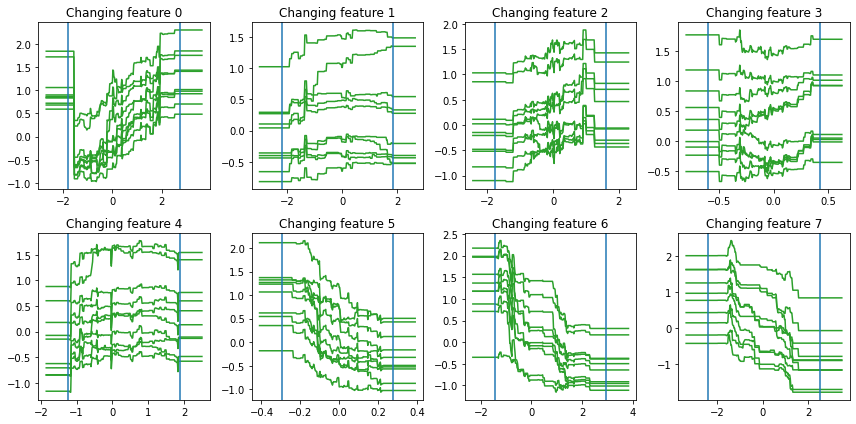

In [ ]:
model = sklearn.ensemble.GradientBoostingRegressor(n_estimators=1000)
model.fit(X_train[:500], y_train[:500])
print(f'Train MSE {mse(y_train[:500], model.predict(X_train[:500])):g}'
      f', Test MSE {mse(y_test[:1500], model.predict(X_test[:1500])):g}')

test_changing_features_and_plot(model)

In [ ]:
!pip install catboost -q

Train MSE 0.0169675, Test MSE 0.18784


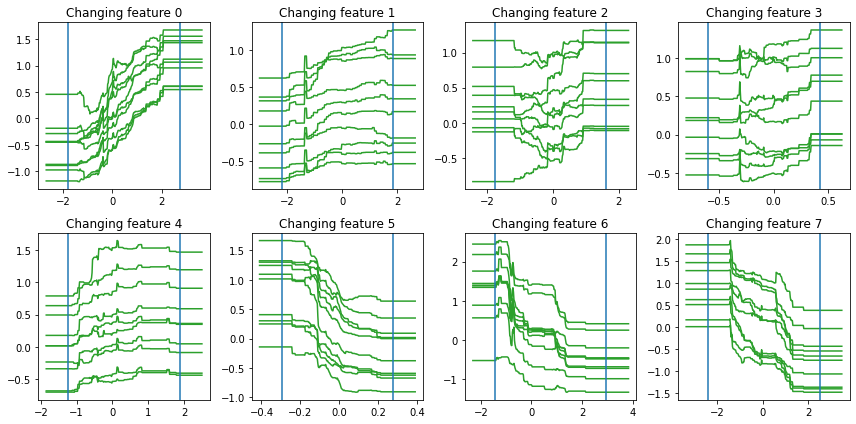

In [ ]:
import catboost

model = catboost.CatBoostRegressor(n_estimators=1000, depth=4, l2_leaf_reg=0)
model.fit(X_train[:500], y_train[:500], verbose=0)
print(f'Train MSE {mse(y_train[:500], model.predict(X_train[:500])):g}'
      f', Test MSE {mse(y_test[:1500], model.predict(X_test[:1500])):g}')

test_changing_features_and_plot(model)

Можно заметить, что в признаке 6 модели градиентного бустинга дают резкий скачок при значении около -0.8, тогда как в нейронных сетях переход намного более плавный. Это может быть важной особенностью, поэтому стоит провести дополнительный эксперимент.

Изменим датасет следующим образом: если признак 4 имеет значение больше 0, то добавим 2 к целевой переменной.Таким образом мы создаем резкий скачок в зависимости целевой переменной от исходных. Проверим сначала, как отреагируют на такое изменение решающие деревья.

Train MSE 0.0179205, Test MSE 0.193297


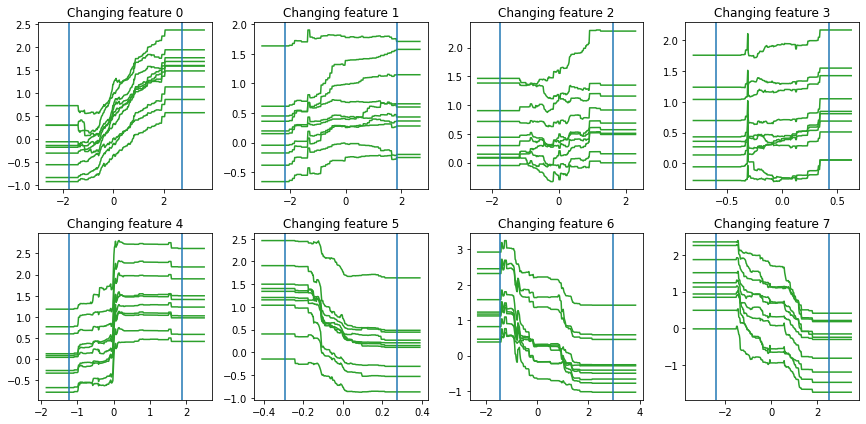

In [ ]:
y_train_changed = y_train.copy()
y_train_changed[X_train[:, 4] > 0] += 1

y_test_changed = y_test.copy()
y_test_changed[X_test[:, 4] > 0] += 1

model = catboost.CatBoostRegressor(n_estimators=1000, depth=4, l2_leaf_reg=0)
model.fit(X_train[:500], y_train_changed[:500], verbose=0)
print(f'Train MSE {mse(y_train_changed[:500], model.predict(X_train[:500])):g}'
      f', Test MSE {mse(y_test_changed[:1500], model.predict(X_test[:1500])):g}')

test_changing_features_and_plot(model)

Решающие деревья легко выучивают эту зависимость, в результате точность предсказания не падает, что естественно: для реализации такой зависимости достаточно добавить всего одно разделяющее правило.

Теперь проверим на этой же задаче нейронные сети.

In [ ]:
model = Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.Dense(2000, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(2000, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(1)
])
untrained_model = copy_model(model)
model.compile(loss='mse', optimizer=Adam(1e-3))
model.fit(X_train[:500], y_train_changed[:500], batch_size=8, epochs=1000, verbose=0,
            validation_data=(X_test[:1500], y_test_changed[:1500]),
            callbacks=EarlyStopping(patience=30, restore_best_weights=True));
report_loss(model, X_train[:500], y_train_changed[:500], X_test[:1500], y_test_changed[:1500])

Epochs: 56, last train MSE 0.138324 min test MSE 0.247255


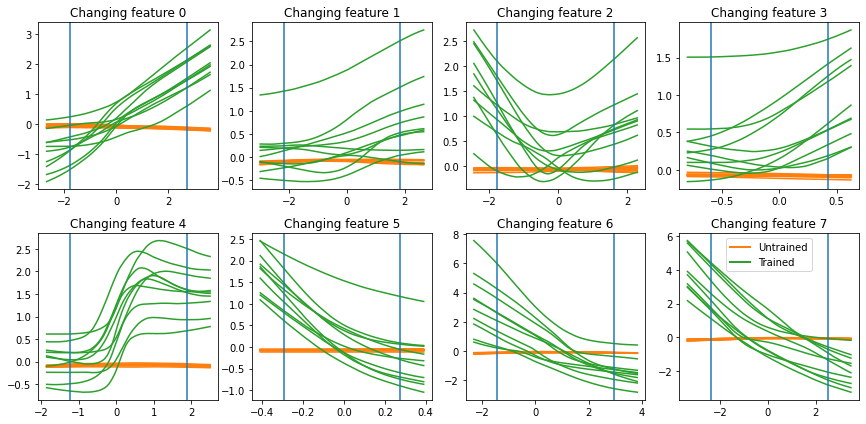

In [ ]:
test_changing_features_and_plot(model, untrained_model)

Как видим, точность нейронных сетей на тестовой выборке существенно ухудшается (с 0.2 до 0.25), при этом зависимость ответа сети от 4-го признака все равно получается плавной.

Конечно, существуют такие веса сети, при которых сеть реализует функцию с резким скачком в точке 0 по признаку 4, однако вероятно такие веса сложно найти оптимизацией. В результате сеть, скорее всего, успеет переобучиться на других признаках прежде, чем найдет верное решение по признаку 4.

Осталось провести еще один эксперимент. Попробуем теперь обучить модели на всех доступных данных, и затем сравним их ответы друг с другом и с ответами моделями, обученными всего на 500 примерах.

In [ ]:
MLP_models_on_large_data = []

for i in range(10):
  model = Sequential([
      layers.InputLayer(X_train.shape[1]),
      layers.Dense(2000, 'relu'),
      layers.Dropout(0.4),
      layers.Dense(2000, 'relu'),
      layers.Dropout(0.4),
      layers.Dense(1)
  ])
  model.compile(loss='mse', optimizer=Adam(5e-4))
  model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0,
              validation_data=(X_test, y_test),
              callbacks=EarlyStopping(patience=10, restore_best_weights=True))
  report_loss(model, X_train, y_train, X_test, y_test)
  MLP_models_on_large_data.append(model)

Epochs: 53, last train MSE 0.121085 min test MSE 0.150828
Epochs: 47, last train MSE 0.127063 min test MSE 0.150761
Epochs: 44, last train MSE 0.130016 min test MSE 0.151814
Epochs: 39, last train MSE 0.132594 min test MSE 0.151228
Epochs: 40, last train MSE 0.130685 min test MSE 0.151219
Epochs: 42, last train MSE 0.130336 min test MSE 0.151089
Epochs: 40, last train MSE 0.134172 min test MSE 0.152091
Epochs: 40, last train MSE 0.131327 min test MSE 0.15218
Epochs: 53, last train MSE 0.1217 min test MSE 0.150198
Epochs: 31, last train MSE 0.14009 min test MSE 0.152527


In [ ]:
GBDT_models_on_large_data = []

for i in range(10):
  model = catboost.CatBoostRegressor(n_estimators=1000, depth=8,
                        grow_policy='Depthwise', l2_leaf_reg=0, random_seed=i)
  model.fit(X_train, y_train, verbose=0)
  print(f'Train MSE {mse(y_train, model.predict(X_train)):g}'
        f', Test MSE {mse(y_test, model.predict(X_test)):g}')
  GBDT_models_on_large_data.append(model)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Train MSE 0.010476, Test MSE 0.111759
Train MSE 0.0107342, Test MSE 0.112504
Train MSE 0.0110047, Test MSE 0.111221
Train MSE 0.0105824, Test MSE 0.112718
Train MSE 0.0102562, Test MSE 0.112488
Train MSE 0.0106061, Test MSE 0.113215
Train MSE 0.010638, Test MSE 0.113009
Train MSE 0.0107504, Test MSE 0.112679
Train MSE 0.0105842, Test MSE 0.11158
Train MSE 0.0103197, Test MSE 0.113508


In [ ]:
MLP_ensebmble_MSE = mse(y_test, np.mean([m.predict(X_test) for m in MLP_models_on_large_data], axis=0))
print(f'MLP ensebmble MSE: {MLP_ensebmble_MSE}')

GBDT_ensebmble_MSE = mse(y_test, np.mean([m.predict(X_test) for m in GBDT_models_on_large_data], axis=0))
print(f'MLP ensebmble MSE: {GBDT_ensebmble_MSE}')

MLP ensebmble MSE: 0.146469465551696
MLP ensebmble MSE: 0.1103129280249415


In [ ]:
model = Sequential([
    layers.InputLayer(X_train.shape[1]),
    layers.Dense(2000, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(2000, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(1)
])
model.compile(loss='mse', optimizer=Adam(5e-4))
model.fit(X_train[:500], y_train[:500], batch_size=32, epochs=100, verbose=0,
            validation_data=(X_test[:500], y_test[:500]),
            callbacks=EarlyStopping(patience=10, restore_best_weights=True))
report_loss(model, X_train[:500], y_train[:500], X_test, y_test)

MLP_model_on_small_data = model

Epochs: 41, last train MSE 0.11312 min test MSE 0.219645


In [ ]:
model = catboost.CatBoostRegressor(n_estimators=1000, depth=8,
                      grow_policy='Depthwise', l2_leaf_reg=0, random_seed=i)
model.fit(X_train[:500], y_train[:500], verbose=0)
print(f'Train MSE {mse(y_train[:500], model.predict(X_train[:500])):g}'
      f', Test MSE {mse(y_test, model.predict(X_test)):g}')

GBDT_model_on_small_data = model

Train MSE 1.41621e-07, Test MSE 0.223559


Возьмем один тестовый пример и сравним на нем все предсказания

In [ ]:
feature_ranges = [get_range(X_train, i, padding=0.2) for i in range(8)]

MLP_predictions_on_large_data = np.array([[
    test_changing_feature(MLP_models_on_large_data[i], X_test[:1],
                          feature_idx=j, values_range=feature_ranges[j])[1]
    for j in range(8)] for i in range(10)]).squeeze()

GBDT_predictions_on_large_data = np.array([[
    test_changing_feature(GBDT_models_on_large_data[i], X_test[:1],
                          feature_idx=j, values_range=feature_ranges[j])[1]
    for j in range(8)] for i in range(10)]).squeeze()

MLP_predictions_on_small_data = np.array([
    test_changing_feature(MLP_model_on_small_data, X_test[:1],
                          feature_idx=j, values_range=feature_ranges[j])[1]
    for j in range(8)]).squeeze()

GBDT_predictions_on_small_data = np.array([
    test_changing_feature(GBDT_model_on_small_data, X_test[:1],
                          feature_idx=j, values_range=feature_ranges[j])[1]
    for j in range(8)]).squeeze()

print(MLP_predictions_on_large_data.shape)
print(GBDT_predictions_on_large_data.shape)
print(MLP_predictions_on_small_data.shape)
print(GBDT_predictions_on_small_data.shape)

(10, 8, 300)
(10, 8, 300)
(8, 300)
(8, 300)


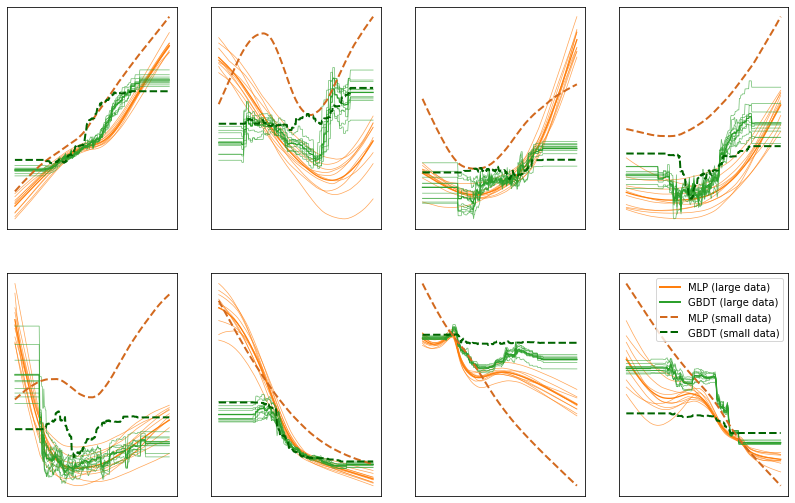

In [ ]:
axes = multi_plot([None] * 8, h=4.5, w=3.5)

for model_idx in range(10):
  multi_plot(MLP_predictions_on_large_data[model_idx], axes=axes, color='C1', lw=0.7, alpha=0.7)
multi_plot(MLP_predictions_on_large_data.mean(axis=0), axes=axes, color='C1', lw=1.3)
for model_idx in range(10):
  multi_plot(GBDT_predictions_on_large_data[model_idx], axes=axes, color='C2', lw=0.7, alpha=0.7)
multi_plot(GBDT_predictions_on_large_data.mean(axis=0), axes=axes, color='C2', lw=1.3)
multi_plot(MLP_predictions_on_small_data, axes=axes, color='chocolate', linestyle='dashed', lw=2)
multi_plot(GBDT_predictions_on_small_data, axes=axes, color='darkgreen', linestyle='dashed', lw=2)

for i, ax in enumerate(axes.flat):
  ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

axes.flat[7].legend(
      [Line2D([0], [0], color='C1', lw=2),
      Line2D([0], [0], color='C2', lw=2),
      Line2D([0], [0], color='chocolate', lw=2, linestyle='dashed'),
      Line2D([0], [0], color='darkgreen', lw=2, linestyle='dashed'),],
      ['MLP (large data)', 'GBDT (large data)',
       'MLP (small data)', 'GBDT (small data)'])
plt.show()

На данных графиках показаны предсказания на первом тестовом примере. Каждый график, как и прежде, соответствует изменению одного из признаков. Зеленым цветом отмечен градиентный бустинг, оранжевым - нейронные сети. Пунктирной линией отмечены предсказания моделей, обученных на небольшом количестве данных.

Прежде всего нужно отметить, что на больших данных (20 тысяч обучающих примеров) градиентный бустинг дает более высокую точность: 0.11 MSE против 0.145. На малых данных (500 обучающих примеров) точность обоих моделей почти одинакова.

Также важным является то, что в данной задаче, признаки могут не задавать цену дома сами по себе, а вместо этого сочетание признаков может позволять определить район города, а район, в свою очередь, определяет цену (исходя из других факторов, нам недоступных). Поэтому для некоторых сочетаний признаков задача предсказания цены может не иметь смысла, так как таких сочетаний не бывает. Иными словами, изменяя каждый признак по отдельности (как на графиках выше) мы можем выйти за пределы многообразия данных, где поведение модели не принципиально.

Все это, в конечном счете, означает, что на приведенных выше графиках вероятно нельзя построить "правильную" зависимость, с которой можно было бы сравнивать предсказания моделей. Предсказания можно лишь сравнивать друг с другом.

**Выводы**

Различные модели предпочитают разные типы решений, зависящие от архитектуры, способа инициализации и обучения. Таким образом, обучая на одной задаче несколько разных моделей, мы получаем несколько решений из разных пространств поиска. Какие-то пространства поиска могут быть неоптимальны в целом или для конкретной задачи.

Например, многослойные нейронные сети с ReLU предпочитают плавные функции. Если истинная зависимость является функцией с резкими скачками (т. е. большими значениями производной), то полученная нейронной сетью аппроксимация, скорее всего, будет более плавной, что может отрицательно сказаться на точности.

В дальнейшем было бы интересно провести следующие эксперименты:
1. Изучить поведение моделей при плавном переходе между парами или тройками тестовых примеров.
2. Изучить поведение большего количества архитектур, в том числе SVM, FT-Transformer, NODE и др.

## Сравнение SP-сетей и ансамблей деревьев небольшой глубины

Ранее была сформулирована гипотеза простой зависимости (simplicity prior), которая говорит о том, что целевая зависимость часто с хорошей точностью аппроксимируется суммой функций от небольшого числа переменных.

Назовем SP-моделями $N$-го порядка такие модели, которые раскладываются в сумму функций от $N$ переменных. Например, ансамбль деревьев глубины 2 является SP-моделью второго порядка. Можно также построить нейронную сеть, являющуюся SP-моделью $N$-го порядка: в ней будут суммироваться ответы нескольких подсетей, работающих не более чем с $N$ признаками.

Даже если SP-модели не достигнут той же точности, что более сложные модели, они все равно могут быть полезны. Такие модели легко интерпретируемы в виде набора графиков от одной или двух переменных. Более сложной моделью можно предсказывать разность между ответом SP-модели и эталонным ответом. Если прирост точности от этого будет небольшой, то полученная суммарная модель будет в большой степени интерпретируема, так как ее интерпретируемая часть (SP-модель) оказывает наибольшее влияние на предсказание.

Построим и протестируем SP-сети на датасете California Housing, используя функции из предыдущего раздела. Начнем с SP-сетей первого порядка и ансамблей деревьев глубины 1.

Train MSE 0.222155, Test MSE 0.232299


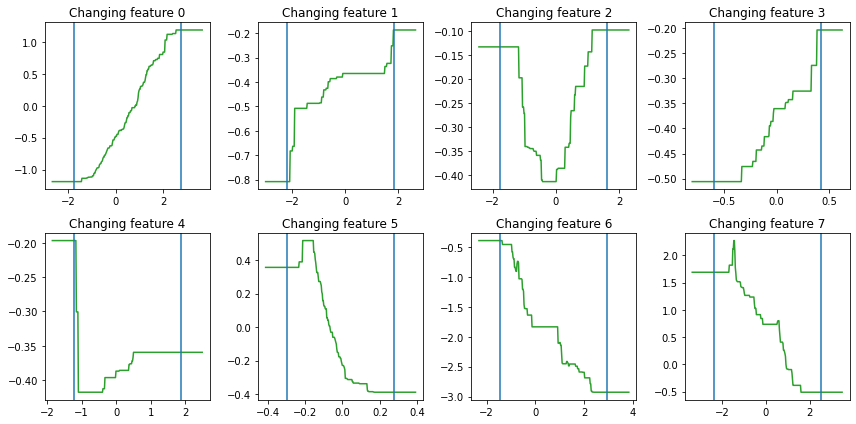

In [ ]:
!pip install catboost -q
import catboost

catboost_model = catboost.CatBoostRegressor(n_estimators=5000, depth=1,
                                            l2_leaf_reg=0, border_count=256)
catboost_model.fit(X_train, y_train, verbose=0)
print(f'Train MSE {mse(y_train, catboost_model.predict(X_train)):g}'
      f', Test MSE {mse(y_test, catboost_model.predict(X_test)):g}')

test_changing_features_and_plot(catboost_model, n_examples=1)

Train MSE 0.202466, Test MSE 0.220402


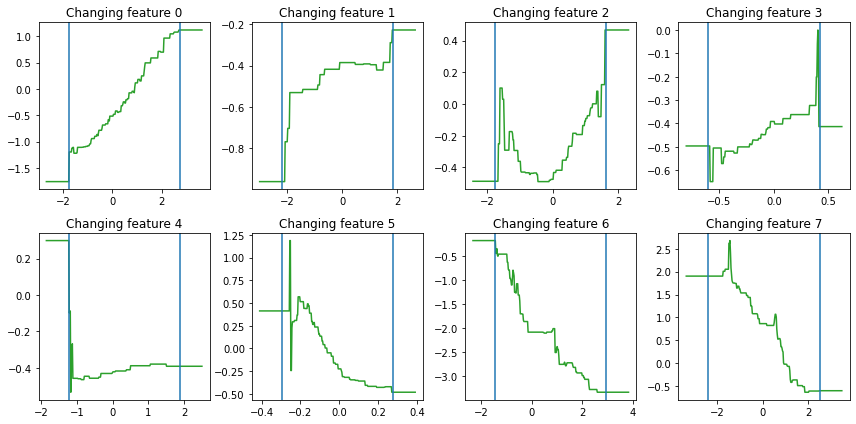

In [ ]:
import xgboost as xgb

xgboost_model = xgb.XGBRegressor(max_depth=1, objective='reg:squarederror', n_estimators=5000)
xgboost_model.fit(X_train, y_train)
print(f'Train MSE {mse(y_train, xgboost_model.predict(X_train)):g}'
      f', Test MSE {mse(y_test, xgboost_model.predict(X_test)):g}')

test_changing_features_and_plot(xgboost_model, n_examples=1)

Отличие от предыдущих экспериментов в том, что полученные графики описывают не поведение модели на конкретных примерах, а показывают **всю модель в явном виде** (этот факт легко проверить, увеличив `n_examples`: будет видно, что зависимость предсказания от каждого признака одинаково для всех примеров с точностью до константы, т. е. не зависит от значений других признаков). Интересно, что переобучения практически не происходит (MSE на обучающей выборке лишь ненамного ниже, чем на тестовой).

Теперь построим нейронную сеть, суммирующую предсказания подсетей, каждая из которых работает с одним признаком.

In [ ]:
from itertools import combinations

def mixture_model(block, n_features, degree):
  input = tf.keras.Input(shape=n_features)
  expert_outputs = []
  combs = list(combinations(range(n_features), r=degree))
  for i, comb in enumerate(combs):
    expert_input = tf.gather(input, list(comb), axis=1)
    block_copy = tf.keras.models.clone_model(block)
    block_copy._name = f'Block_{i}'
    expert_output = block_copy(expert_input) + layers.Dense(1, use_bias=False,
                                                    kernel_initializer='zeros')(expert_input)
    expert_outputs.append(expert_output)
  sum_experts = tf.math.reduce_mean(tf.concat(expert_outputs, axis=1),
                                   axis=1, keepdims=True)
  output = sum_experts
  return tf.keras.Model(input, output)

In [ ]:
nn_model = mixture_model(Sequential([
    layers.Dense(150, 'relu'),
    layers.Dropout(0.4),
    layers.Dense(150, 'relu'),
    layers.Dense(1),
]), n_features=8, degree=1)

untrained_nn_model = copy_model(nn_model)
nn_model.compile(loss='mse', optimizer=Adam(1e-3))

nn_model.fit(X_train, y_train, batch_size=64, epochs=1000, verbose=1,
            validation_data=(X_test, y_test),
            callbacks=EarlyStopping(patience=30, restore_best_weights=True));

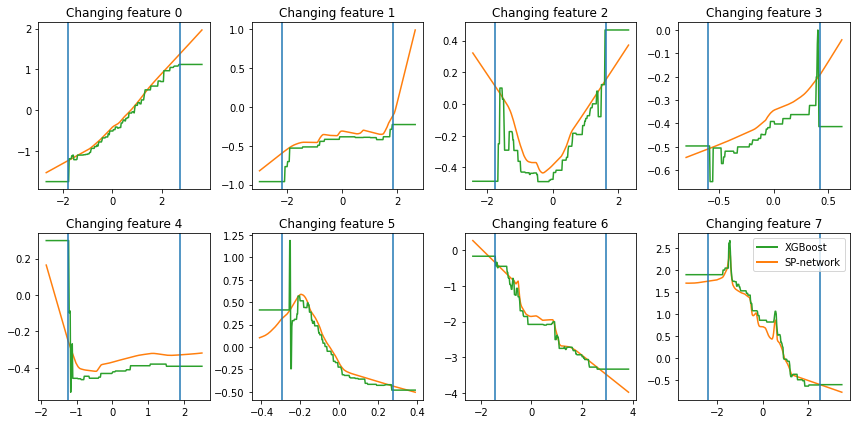

In [ ]:
test_changing_features_and_plot(xgboost_model, nn_model, n_examples=1,
                labels=['XGBoost', 'SP-network'])

Попробуем обучить нейронную сеть в другом виде: теперь она будет запоминать значения с заданным шагом 0.1.

In [ ]:
#from -3 to 3
nn2_model = mixture_model(Sequential([
    layers.GaussianNoise(stddev=0.02),
    layers.Lambda(lambda x: tf.cast((x + 3)*10, tf.int32)),
    layers.Embedding(input_dim=60, output_dim=1, embeddings_initializer='zeros'),
    layers.Lambda(lambda x: x[:, 0, :])
]), n_features=8, degree=1)

nn2_model.compile(loss='mse', optimizer=Adam(1e-3))
nn2_model.fit(X_train, y_train, batch_size=64, epochs=1000, verbose=1,
            validation_data=(X_test, y_test),
            callbacks=EarlyStopping(patience=30, restore_best_weights=True));

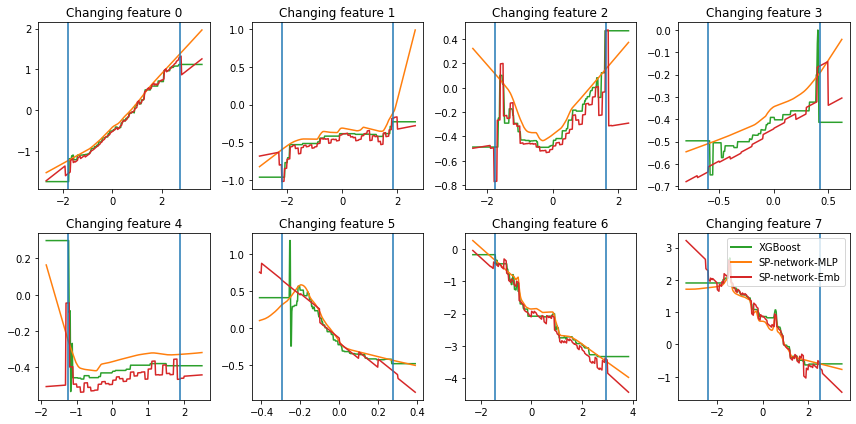

In [ ]:
test_changing_features_and_plot(xgboost_model, nn_model, nn2_model, n_examples=1,
                labels=['XGBoost', 'SP-network-MLP', 'SP-network-Emb'])

Все три модели приходят примерно к одному и тому же решению и дают примерно одинаковую точность.

## SP-бустинг

Назовем SP-бустингом следующий алгоритм:
1. На данных обучается SP-модель 1-го порядка
2. На градиенте функции потерь обучается SP-модель 2-го порядка
3. На градиенте функции потерь обучается SP-модель 3-го порядка
4. И так далее

В случае решающих деревьев это означает, что мы сначала обучаем деревья глубины 1, затем деревья глубины 2, и так далее. Попробуем реализовать SP-бустинг с помощью XGBoost. Так как мы используем функцию потерь MSE, предсказание градиента функции потерь означает предсказание разности между предсказанием и верным ответом.

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
import xgboost as xgb

class BoostingRegressor(BaseEstimator, RegressorMixin):
  def __init__(self, models_sequence):
    self.models_sequence = [clone(m) for m in models_sequence]
  def fit(self, X, y, validation_data=None, **fit_params):
    sum_train_predictions = np.zeros_like(y)
    if validation_data is not None:
      X_test, y_test = validation_data
      sum_test_predictions = np.zeros_like(y_test)
    for i, model in enumerate(self.models_sequence):
      model.fit(X, y - sum_train_predictions, **fit_params)
      sum_train_predictions += model.predict(X)
      train_loss = mse(y, sum_train_predictions)
      if validation_data is not None:
        sum_test_predictions += model.predict(X_test)
        test_loss = mse(y_test, sum_test_predictions)
      print(f'Model {i}: train MSE={train_loss:g}' +
            (f', test MSE={test_loss:g}' if X_test is not None else ''))
    return self
  def predict(self, X):
    return self.staged_predict(X).sum(axis=1)
  def staged_predict(self, X):
    return np.array([m.predict(X) for m in self.models_sequence]).T

In [ ]:
# по 1000 деревьев каждой глубины (с 1 до 5)
BoostingRegressor([
    xgb.XGBRegressor(max_depth=1, objective='reg:squarederror', n_estimators=1000),
    xgb.XGBRegressor(max_depth=2, objective='reg:squarederror', n_estimators=1000),
    xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', n_estimators=1000),
    xgb.XGBRegressor(max_depth=4, objective='reg:squarederror', n_estimators=1000),
    xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', n_estimators=1000),
]).fit(X_train, y_train, validation_data=(X_test, y_test));

Model 0: train MSE=0.17845, test MSE=0.186329
Model 1: train MSE=0.111801, test MSE=0.134268
Model 2: train MSE=0.064801, test MSE=0.123738
Model 3: train MSE=0.0295365, test MSE=0.123188
Model 4: train MSE=0.00985373, test MSE=0.122144


In [ ]:
# увеличим количество деревьев каждой глубины
BoostingRegressor([
    xgb.XGBRegressor(max_depth=1, objective='reg:squarederror', n_estimators=5000),
    xgb.XGBRegressor(max_depth=2, objective='reg:squarederror', n_estimators=5000),
    xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', n_estimators=4000),
    xgb.XGBRegressor(max_depth=4, objective='reg:squarederror', n_estimators=3000),
    xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', n_estimators=2000),
]).fit(X_train, y_train, validation_data=(X_test, y_test));

Model 0: train MSE=0.160444, test MSE=0.171556
Model 1: train MSE=0.0648584, test MSE=0.126138
Model 2: train MSE=0.0200108, test MSE=0.125743
Model 3: train MSE=0.00445845, test MSE=0.128407
Model 4: train MSE=0.000867274, test MSE=0.129406


In [ ]:
# будем обучать сразу деревья максимальной глубины
BoostingRegressor([
    xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', n_estimators=1000),
]).fit(X_train, y_train, validation_data=(X_test, y_test))
BoostingRegressor([
    xgb.XGBRegressor(max_depth=5, objective='reg:squarederror', n_estimators=5000),
]).fit(X_train, y_train, validation_data=(X_test, y_test));

Model 0: train MSE=0.0218005, test MSE=0.118656
Model 0: train MSE=0.000483551, test MSE=0.119452


In [ ]:
!pip install catboost -q

In [15]:
# CatBoost, по 1000 деревьев каждой глубины (с 1 до 5)
import catboost
BoostingRegressor([
    catboost.CatBoostRegressor(max_depth=1, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=2, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=3, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=4, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=5, n_estimators=1000),
]).fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0);

Model 0: train MSE=0.194717, test MSE=0.200115
Model 1: train MSE=0.132231, test MSE=0.140741
Model 2: train MSE=0.101388, test MSE=0.12297
Model 3: train MSE=0.0771285, test MSE=0.116831
Model 4: train MSE=0.0551932, test MSE=0.112516


In [ ]:
# CatBoost, увеличим количество деревьев
import catboost
BoostingRegressor([
    catboost.CatBoostRegressor(max_depth=1, n_estimators=5000),
    catboost.CatBoostRegressor(max_depth=2, n_estimators=5000),
    catboost.CatBoostRegressor(max_depth=3, n_estimators=4000),
    catboost.CatBoostRegressor(max_depth=4, n_estimators=3000),
    catboost.CatBoostRegressor(max_depth=5, n_estimators=2000),
]).fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0);

Model 0: train MSE=0.186912, test MSE=0.192071
Model 1: train MSE=0.125608, test MSE=0.136077
Model 2: train MSE=0.0955673, test MSE=0.122084
Model 3: train MSE=0.0709652, test MSE=0.116131
Model 4: train MSE=0.0499824, test MSE=0.112699


In [ ]:
# CatBoost, будем обучать сразу деревья максимальной глубины
import catboost
BoostingRegressor([
    catboost.CatBoostRegressor(max_depth=5, n_estimators=1000),
]).fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0)
BoostingRegressor([
    catboost.CatBoostRegressor(max_depth=5, n_estimators=5000),
]).fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0);

Model 0: train MSE=0.0796653, test MSE=0.115635
Model 0: train MSE=0.0685036, test MSE=0.112314


Как видим, SP-бустинг несколько уступает в точности стандартному подходу, когда обучаются сразу деревья максимальной глубины. Более того, увеличение количества деревьев небольшой глубины приводит к тому, что деревья большой глубины больше не дают выигрыша в точности при тестировании, а дают лишь переобучение.

Скорее всего, причина этого следующая: если мы обучаем деревья глубины $N$, обучив перед этим много деревьев глубины $N-1$, то первые $N$ разделяющих правил практически не дадут выигрыша в точности, что может помешать найти оптимальное решение.

Могут быть разные варианты решения этой проблемы:
1. Использовать случайные решающие деревья.
2. Использовать на первых уровнях разделяющие правила, взятые из деревьев меньшей глубины.
3. Обучать деревья всех уровней в случайном порядке, или обучать всю SP-модель параллельно (в случае нейронных сетей). Но это может привести к другой проблеме: SP-модели 1-2 уровней будут построены неоптимально, так как в их построение вмешивались модели следующих уровней.

Интересно, что CatBoost практически не подвержен такой проблеме.

## Проблема косвенной зависимости

(нашел ошибку в разделе, раздел пока не актуален)

Посмотрим еще раз на решения, получаемые на датасете California Housing SP-моделями первого порядка на признаках 6 и 7 (описание признаков см. [здесь](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)).

~~*Признак 6.* "Total number of households, a group of people residing within a home unit, for a block."~~

~~*Признак 7.* "Median income for households within a block of houses (measured in tens of thousands of US Dollars)."~~

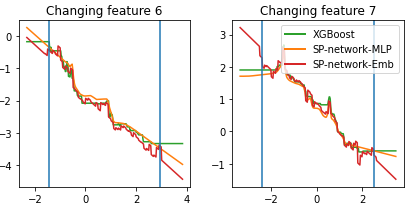

На обоих графиках видна общая зависимость, в которой встречаются аномалии, обнаруживаемые всеми моделями. Чем они могут быть вызваны?

Вполне возможно, что признаки 6 и 7 влияют на ответ не только прямо, но и косвенно, позволяя предсказывать, скажем, район города. Этот район, в свою очередь, имеет свой множитель цены на недвижимость (который может быть вызван факторами, отсутствующими в датасете).

Более того, район городе может быть предсказан на основании не только одного признака, но и сочетания признаков, и функция, отображающая сочетание признаков в район, может иметь очень сложный вид, не сводимый к сумме функций от небольшого числа переменных. Кроме того, такая функция может содержать резкие границы, из-за чего деревья могут находить ее легче, чем MLP-сети.

Например, параметр "близость к реке" может влиять на цену непосредственно, и эта зависимость будет плавной, а может также влиять косвенно, позволяя предсказать район, и эта зависимость уже будет содержать резкие переходы.

Надо отметить, что в датасете California Housing есть параметры "долгота" и "широта", позволяющие определять район непосредственно. Зная это, множитель можно вычислять как функцию от долготы и широты. Но если мы ходим обучать модели, в явном виде реализующие SP-гипотезу, то в каком порядке должны обучаться (а) модели от одной переменной и (б) модель от долготы и широты? Есть разные варианты:

1. Сначала модели от одной переменной. Но тогда получаемые ими функции будут содержать аномалии, как на рисунке выше. Возможно, их придется убирать вручную прежде, чем обучать следующие модели. Но так мы можем получить еще больше проблем, потому что не всегда понятно, что является аномалией, а что непосредственным влиянием.
2. Сначала модель от долготы и широты. Но если эта модель "не знает" о зависимости цены от других факторов, то она может предсказывать большую цену в районе А, чем в районе Б, потому что там в среднем квартиры большей площади. Но если зависимость цены от площади учесть заранее, то может оказаться, что множитель цены в районах А и Б одинаков. Иными словами, модель от долготы и широты окажется неверной, и на обучаемых вслед за ней моделях от одной переменной снова будут аномалии.
3. Все модели обучаются одновременно. Кажется, что этот подход позволяет решить описанные выше проблемы. Остается открытым вопрос о том, не создаст ли он новых проблем.

### Интерпретация SP-бустинга

Попробуем понять, как функционирует обученный SP-бустинг и можно ли его интерпретировать.

In [86]:
import catboost
model = BoostingRegressor([
    catboost.CatBoostRegressor(max_depth=1, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=2, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=3, n_estimators=1000),
    catboost.CatBoostRegressor(max_depth=4, n_estimators=1000),
]).fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0);

Model 0: train MSE=0.194717, test MSE=0.200115
Model 1: train MSE=0.132231, test MSE=0.140741
Model 2: train MSE=0.101388, test MSE=0.12297
Model 3: train MSE=0.0771285, test MSE=0.116831


Определим вклад каждого уровня бустинга в ответ на тестовых примерах:

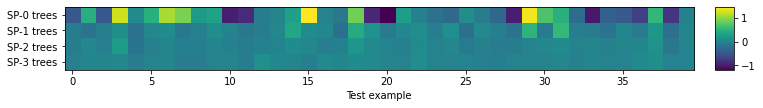

In [87]:
preds = model.staged_predict(X_test)

plt.figure(figsize=(12, 3))
im = plt.imshow(preds[:40].T)

plt.gca().set_yticks(range(4))
plt.gca().set_yticklabels([f'SP-{i} trees' for i in range(preds.shape[1])]);
plt.xlabel('Test example')

from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.colorbar(im, cax=make_axes_locatable(plt.gca()).append_axes('right', size='3%', pad=0.3));

Во всех примерах основной вклад в ответ вносят деревья глубины 1-2. Такие деревья являются функцией от 1-2 переменных, и их работу можно показать на графиках.

Сгруппируем деревья каждой глубины по используемым признакам.

In [91]:
import json, collections

def find_in_list(lst, value):
  return np.array([i for i, f in enumerate(lst) if f == value])

tree_indices = []

for level in range(4):
  catboost_model.models_sequence[level].save_model('model.json', format='json')
  model_json = json.load(open('model.json', 'r'))
  tree_splits = [tuple(sorted(s['float_feature_index'] for s in m['splits']))
        for m in model_json['oblivious_trees']]
  splits_counter = collections.Counter(tree_splits).most_common()
  tree_indices.append(collections.OrderedDict([(features, find_in_list(tree_splits, features))
                  for features, count in splits_counter]))

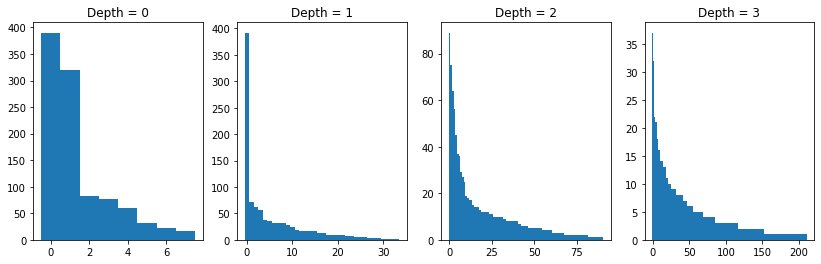

In [103]:
fig, axes = plt.subplots(ncols=4, figsize=(14, 4), squeeze=False)
for level, ax in enumerate(axes.flat):
  counts = [len(x) for x in tree_indices[level].values()]
  ax.bar(range(len(counts)), counts, width=1)
  ax.set_title(f'Depth = {level}')

Каждый график выше соответствует деревьям определенной глубины, от 1 до 4. Каждый столбец соответствует одному сочетанию признаков, высота столбца - количество деревьев, использующих это сочетание. Например, на уровне 4 есть такое сочетание признаков, которое используется в 37 деревьях, а около 60 сочетаний признаков используются только в одном дереве.

Разобьем модель в сумму функций, каждая из которых использует уникальное сочетание переменных. Изучим вклад этих функций в предсказание.

In [160]:
features = []
predictions = []

for level in range(4):
  catboost_model = model.models_sequence[level]
  staged_predictions = np.array(list(catboost_model.staged_predict(X_test)))
  staged_predictions = np.concatenate([np.zeros((1, staged_predictions.shape[1])),
                                       staged_predictions], axis=0)
  staged_predictions = np.diff(staged_predictions, axis=0)
  for f, idxs in tree_indices[level].items():
    features.append(f)
    predictions.append(staged_predictions[idxs].sum(axis=0))

predictions = np.array(predictions)

In [163]:
predictions.shape

(344, 5760)

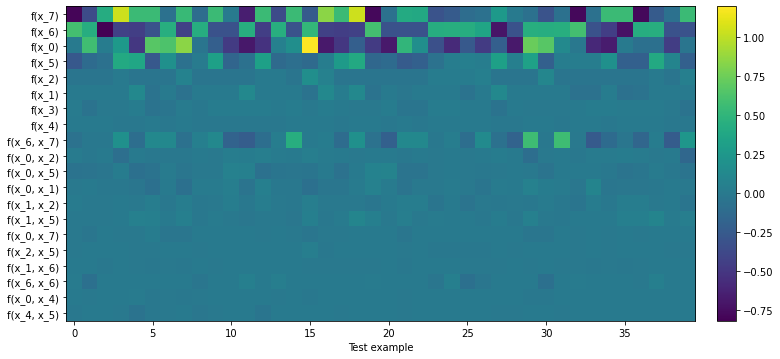

In [175]:
num_functions = 20

plt.figure(figsize=(12, num_functions/1.5))
im = plt.imshow(predictions[:num_functions, :40])

plt.gca().set_yticks(range(num_functions))
plt.gca().set_yticklabels(['f(' + ', '.join([f'x_{_f}' for _f in f]) + ')'
                            for f in features[:num_functions]]);
plt.xlabel('Test example')

from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.colorbar(im, cax=make_axes_locatable(plt.gca()).append_axes('right', size='3%', pad=0.3));

Упорядочим функции по сумме модулей их значений в предсказании на тестовой выборке.

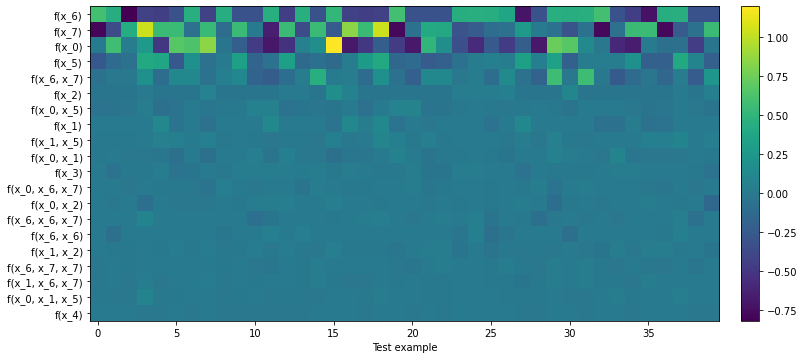

In [190]:
most_important_functions = np.argsort(np.abs(predictions).mean(axis=1))[::-1]

predictions_sorted = predictions[most_important_functions]
features_sorted = np.array(features, dtype=object)[most_important_functions]

num_functions = 20

plt.figure(figsize=(12, num_functions/1.5))
im = plt.imshow(predictions_sorted[:num_functions, :40])

plt.gca().set_yticks(range(num_functions))
plt.gca().set_yticklabels(['f(' + ', '.join([f'x_{_f}' for _f in f]) + ')'
                            for f in features_sorted[:num_functions]]);
plt.xlabel('Test example')

from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.colorbar(im, cax=make_axes_locatable(plt.gca()).append_axes('right', size='3%', pad=0.3));

Теперь посмотрим, как выглядит функции от 6-го, 7-го признаков (широта и долгота) и их комбинации.

In [231]:
def get_func_from_model(model, level, features, n_model_features):
  catboost_model = model.models_sequence[level]
  idxs = tree_indices[level][features]
  def func(X):
    inputs = np.zeros((len(X), n_model_features))
    for i, f in enumerate(features):
      inputs[:, f] = X[:, i]
    staged_predictions = np.array(list(catboost_model.staged_predict(inputs)))
    staged_predictions = np.concatenate([np.zeros((1, staged_predictions.shape[1])),
                                       staged_predictions], axis=0)
    staged_predictions = np.diff(staged_predictions, axis=0)
    return staged_predictions[idxs].sum(axis=0)
  return func

def evaluate_function(func, variables, X_for_estimate_ranges, num_per_axis=100):
  linspaces = [np.linspace(X_for_estimate_ranges[:, v].min(),
                           X_for_estimate_ranges[:, v].max(),
                           num=num_per_axis) for v in variables]
  inputs = np.stack([x.flatten() for x in np.meshgrid(*linspaces)], axis=1)
  outputs = func(inputs).reshape([num_per_axis for _ in range(len(variables))])
  return linspaces, outputs

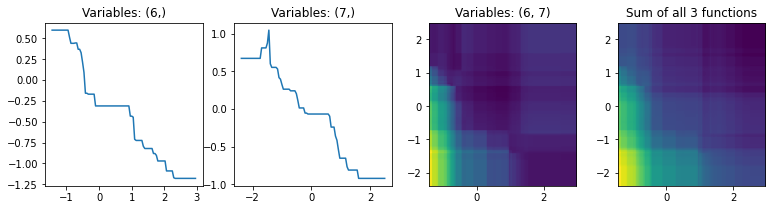

In [233]:
f6 = get_func_from_model(model, level=0, features=(6,), n_model_features=8)
f7 = get_func_from_model(model, level=0, features=(7,), n_model_features=8)
f67 = get_func_from_model(model, level=1, features=(6, 7), n_model_features=8)

fig, axes = plt.subplots(ncols=4, figsize=(13, 3), squeeze=False)
evaluated_all = []
for func, vars, ax in zip([f6, f7, f67], [(6,), (7,), (6, 7)], axes.flat):
  ranges, evaluated = evaluate_function(func, vars, X_for_estimate_ranges=X_train)
  if len(vars) == 1:
    ax.plot(ranges[0], evaluated)
  elif len(vars) == 2:
    ax.imshow(evaluated, origin='lower',
              extent=(ranges[0][0], ranges[0][-1], ranges[1][0], ranges[1][-1]))
  ax.set_title(f'Variables: {vars}')
  evaluated_all.append(evaluated)

evaluated_sum = evaluated_all[2] + evaluated_all[0][:, None] + evaluated_all[0][None, :]
axes.flat[3].imshow(evaluated_sum, origin='lower',
                    extent=(ranges[0][0], ranges[0][-1], ranges[1][0], ranges[1][-1]))
axes.flat[3].set_title('Sum of all 3 functions')
plt.show()

In [227]:
mse(y_test, predictions_sorted[[0, 1, 4]].sum(axis=0))

0.4073002138402326

In [ ]:
# fig, axes = plt.subplots(ncols=4, figsize=(14, 4), squeeze=False)

# #test_parts = [slice(0, 1440), slice(1440, 2880), slice(2880, 4320), slice(4320, 5760)]
# test_parts = [slice(0, 5760)]

# sum_predictions = np.zeros_like(y_test)
# for level, ax in enumerate(axes.flat):
#   loss_trends = [[mse(y_test[p], sum_predictions[p])] for p in test_parts]
#   trees_count = [0]
#   catboost_model = model.models_sequence[level]
#   staged_predictions = np.array(list(catboost_model.staged_predict(X_test)))
#   staged_predictions = np.concatenate([np.zeros((1, staged_predictions.shape[1])),
#                                        staged_predictions], axis=0)
#   staged_predictions = np.diff(staged_predictions, axis=0)
#   for features, idxs in tree_indices[level].items():
#     predictions = staged_predictions[idxs].sum(axis=0)
#     sum_predictions += predictions
#     for i, p in enumerate(test_parts):
#       loss_trends[i].append(mse(y_test[p], sum_predictions[p]))
#     trees_count.append(trees_count[-1] + len(idxs))
#   for i, p in enumerate(test_parts):
#     ax.plot(trees_count, loss_trends[i])
# plt.tight_layout()